Hoja de trabajo 2 DataScience - Series de tiempo

Andree Toledo
Andres Quinto 18288



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.cm as cm
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from apyori import apriori
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.set_option('display.max_rows', None)

Analisis Exploratorio

In [2]:
IMPORT = pd.read_excel('./IMPORTACION-VOLUMEN-2022-05.xlsx', skiprows=6)
CONSUME = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
# print(IMPORT.columns)
# print(CONSUME.columns)

Pequeño fix para nombres de la columna

In [3]:
IMPORT.rename(columns={'Gasolina superior': 'Gasolinasuperior','Gasolina regular': 'Gasolinaregular'}, inplace=True)
CONSUME.rename(columns={'Gasolina superior': 'Gasolinasuperior','Gasolina regular': 'Gasolinaregular'}, inplace=True)

In [45]:
Relevantes=['Fecha', 'Gasolinasuperior', 'Gasolinaregular', 'Diesel']
SinFecha=['Gasolina superior', 'Gasolina regular', 'Diesel']
consumes = CONSUME[Relevantes]
imports = IMPORT[Relevantes]


# a partir de la linea 264 ya no se toma en relevancia para la interpretacion de datos
CONSUME = CONSUME[:264]
IMPORT = IMPORT[:264]
consumes = consumes[:270]
imports = imports[:270]

In [5]:
consumes.head(15)

,Fecha,Gasolinasuperior,Gasolinaregular,Diesel
0,2000-01-01 00:00:00,308156.82,202645.2,634667.06
1,2000-02-01 00:00:00,307766.31,205530.96,642380.66
2,2000-03-01 00:00:00,331910.29,229499.56,699807.25
3,2000-04-01 00:00:00,315648.08,210680.4,586803.98
4,2000-05-01 00:00:00,319667.97,208164.34,656948.2
5,2000-06-01 00:00:00,300347.7,195088.74,570919.88
6,2000-07-01 00:00:00,308305.93,204556.77,576436.02
7,2000-08-01 00:00:00,323011.86,218388.51,593770.77
8,2000-09-01 00:00:00,326455.72,213906.96,590145.4
9,2000-10-01 00:00:00,323843.63,213606.65,641113.36


In [6]:
consumes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Fecha             270 non-null    object
 1   Gasolinasuperior  270 non-null    object
 2   Gasolinaregular   270 non-null    object
 3   Diesel            270 non-null    object
dtypes: object(4)
memory usage: 8.6+ KB


In [7]:
imports.head(15)


,Fecha,Gasolinasuperior,Gasolinaregular,Diesel
0,2001-01-01,373963.96,177776.5,566101.99
1,2001-02-01,243091.07,123115.99,489525.8
2,2001-03-01,312084.38,161726.42,575559.68
3,2001-04-01,285054.89,127338.74,437745.42
4,2001-05-01,300913.67,168730.19,552609.13
5,2001-06-01,333217.19,152899.09,497855.26
6,2001-07-01,195071.86,136299.13,302350.02
7,2001-08-01,268153.26,139365.07,464159.13
8,2001-09-01,308439.07,233643.75,321952.94
9,2001-10-01,305102.28,141550.22,438989.55


In [8]:
imports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             264 non-null    datetime64[ns]
 1   Gasolinasuperior  264 non-null    object        
 2   Gasolinaregular   264 non-null    object        
 3   Diesel            264 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 8.6+ KB


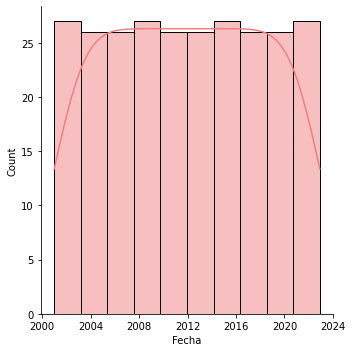

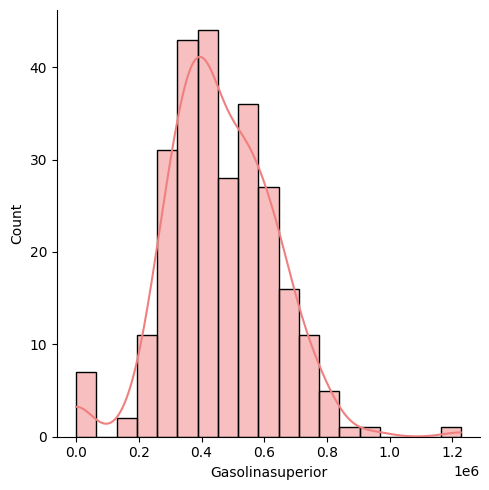

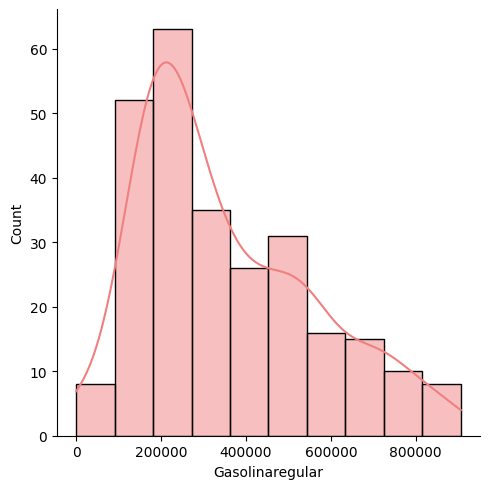

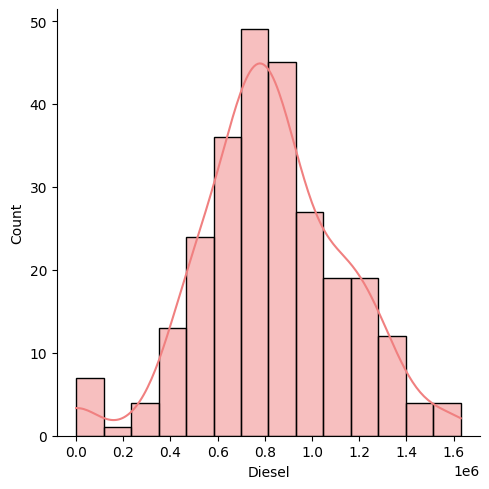

In [9]:
for var in Relevantes:
    sns.displot(imports[var], kde=True, color = 'lightcoral')

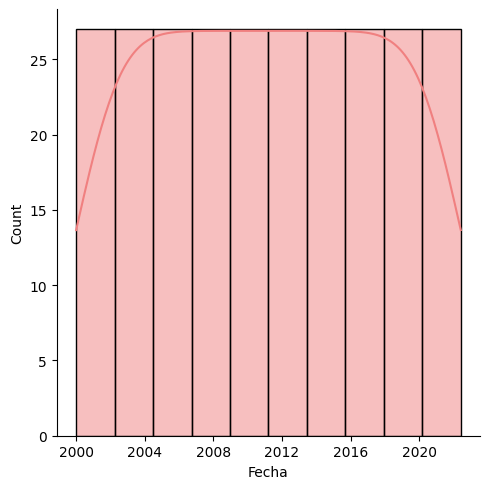

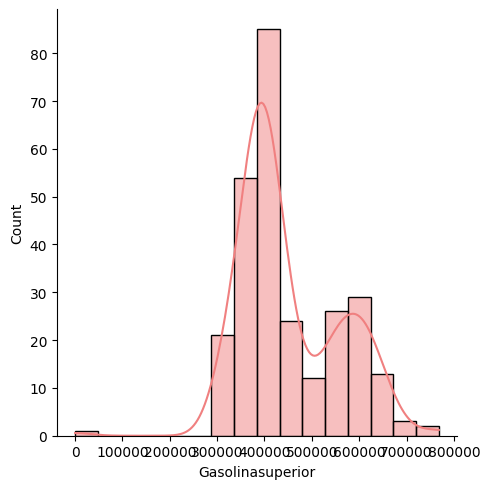

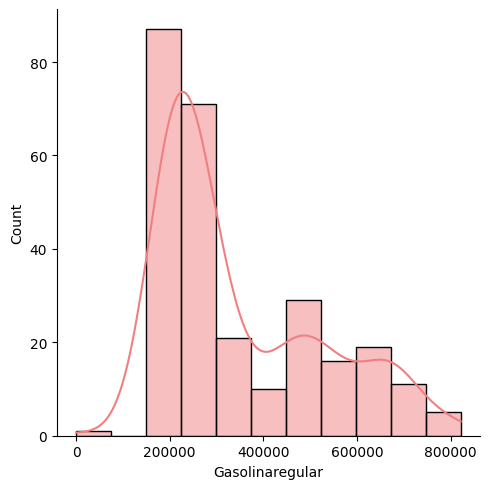

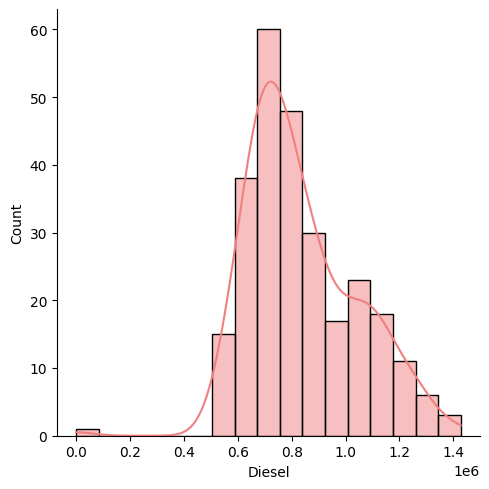

In [10]:
for var in Relevantes:
    sns.displot(consumes[var], kde=True, color='lightcoral')

(array([ 1.,  0.,  0., 11., 74., 80., 41., 38., 19.,  6.]),
 array([0.0, 142788.803, 285577.606, 428366.40900000004, 571155.212,
        713944.0150000001, 856732.8180000001, 999521.621, 1142310.424,
        1285099.2270000002, 1427888.03], dtype=object),
 <BarContainer object of 10 artists>)

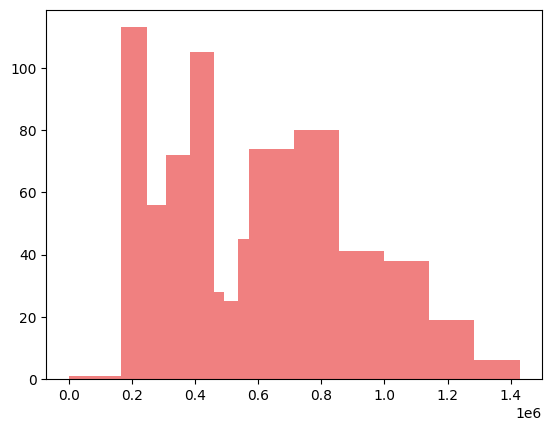

In [16]:
plt.hist(consumes.Gasolinaregular, color="lightcoral")

(array([  1.,   0.,   0.,   3.,  72., 105.,  19.,  45.,  22.,   3.]),
 array([0.0, 76810.283, 153620.566, 230430.849, 307241.132, 384051.415,
        460861.698, 537671.9809999999, 614482.264, 691292.547, 768102.83],
       dtype=object),
 <BarContainer object of 10 artists>)

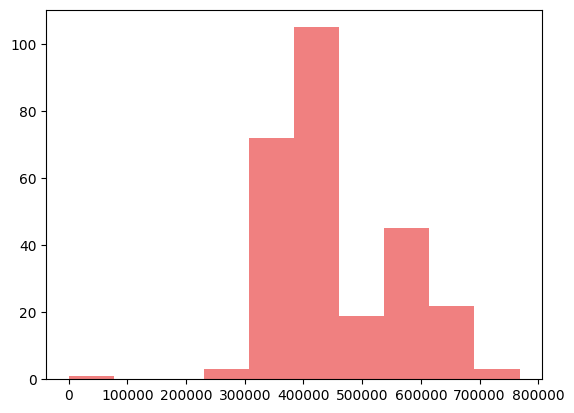

In [17]:
plt.hist(consumes.Gasolinasuperior, color="lightcoral")


(array([ 1.,  0.,  0., 11., 74., 80., 41., 38., 19.,  6.]),
 array([0.0, 142788.803, 285577.606, 428366.40900000004, 571155.212,
        713944.0150000001, 856732.8180000001, 999521.621, 1142310.424,
        1285099.2270000002, 1427888.03], dtype=object),
 <BarContainer object of 10 artists>)

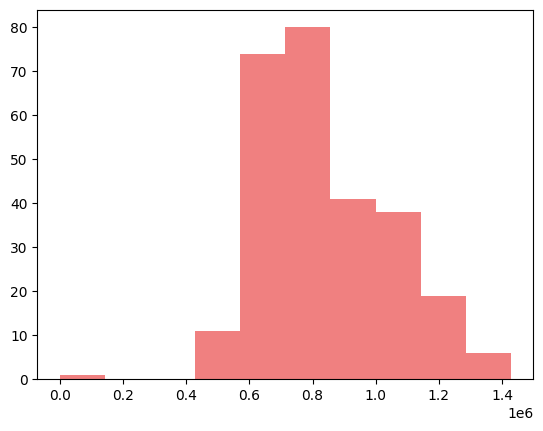

In [18]:
plt.hist(consumes.Diesel, color="lightcoral")

c:\Users\aeqv2\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\aeqv2\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 8., 52., 63., 35., 26., 31., 16., 15., 10.,  8.]),
 array([0.0, 90610.405, 181220.81, 271831.21499999997, 362441.62,
        453052.025, 543662.4299999999, 634272.835, 724883.24, 815493.645,
        906104.05], dtype=object),
 <BarContainer object of 10 artists>)

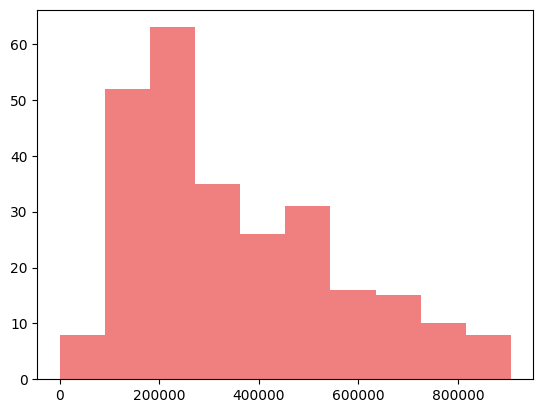

In [20]:
plt.hist(imports.Gasolinaregular, color="lightcoral")

c:\Users\aeqv2\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\aeqv2\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 7.,  8., 63., 74., 60., 41.,  9.,  1.,  0.,  1.]),
 array([0.0, 122717.353, 245434.706, 368152.059, 490869.412, 613586.765,
        736304.118, 859021.471, 981738.824, 1104456.1770000001, 1227173.53],
       dtype=object),
 <BarContainer object of 10 artists>)

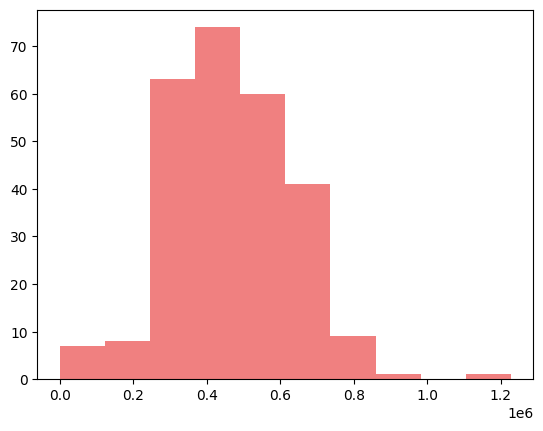

In [21]:
plt.hist(imports.Gasolinasuperior, color="lightcoral")

(array([ 7.,  3., 18., 40., 66., 54., 33., 28., 10.,  5.]),
 array([0.0, 163063.564, 326127.128, 489190.69200000004, 652254.256,
        815317.8200000001, 978381.3840000001, 1141444.948, 1304508.512,
        1467572.0760000001, 1630635.6400000001], dtype=object),
 <BarContainer object of 10 artists>)

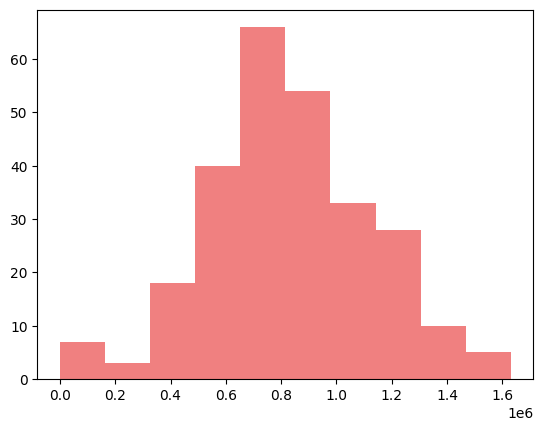

In [22]:
plt.hist(imports.Diesel, color="lightcoral")

A través de este análisis exploratorio se pudo observar que todos los datos son de tipo flotante para las 3 variables, además de que no existen objetos de un tipo extraño que necesiten ser limpiados. Por otra parte a través de los histogramas podemos observar que las distribuciones de las mismas, siendo la de disel la única con distribución normal tanto par aimportación como para consumo

In [26]:
print(IMPORT.head())

  Unnamed: 0      Fecha Gasolinasuperior Gasolinaregular Total\ngasolinas  \
0        NaN 2001-01-01        373963.96        177776.5        551740.46   
1        NaN 2001-02-01        243091.07       123115.99        366207.06   
2        NaN 2001-03-01        312084.38       161726.42         473810.8   
3        NaN 2001-04-01        285054.89       127338.74        412393.63   
4        NaN 2001-05-01        300913.67       168730.19        469643.86   

  Diesel alto azufre Diesel bajo azufre Diesel ultra bajo azufre     Diesel  \
0          566101.99                  0                        0  566101.99   
1           489525.8                  0                        0   489525.8   
2          575559.68                  0                        0  575559.68   
3          437745.42                  0                        0  437745.42   
4          552609.13                  0                        0  552609.13   

  Gas licuado de petróleo  ... Solventes Naftas Ceras Butano  

In [43]:
cols=["Fecha"]
IMPORT['date'] = pd.to_datetime(IMPORT[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns"), format='%Y-%m', errors='ignore')
CONSUME['date'] = pd.to_datetime(CONSUME[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns"))

<AxesSubplot:xlabel='date'>

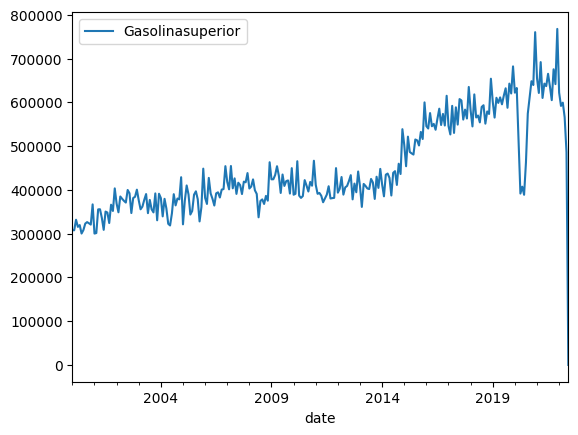

In [47]:
CONSUME.plot(x='date', y='Gasolinasuperior', style='-')

<AxesSubplot:xlabel='date'>

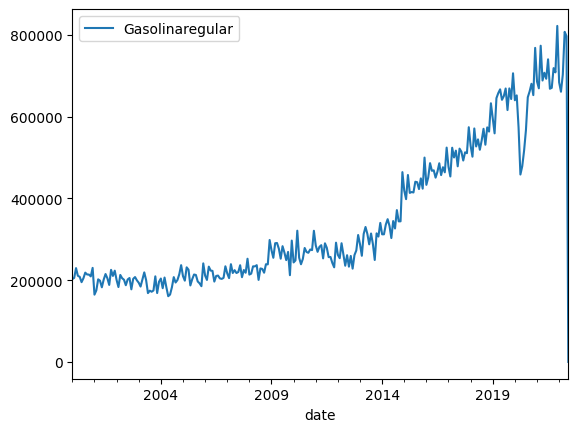

In [49]:
CONSUME.plot(x='date', y='Gasolinaregular', style='-')

<AxesSubplot:xlabel='date'>

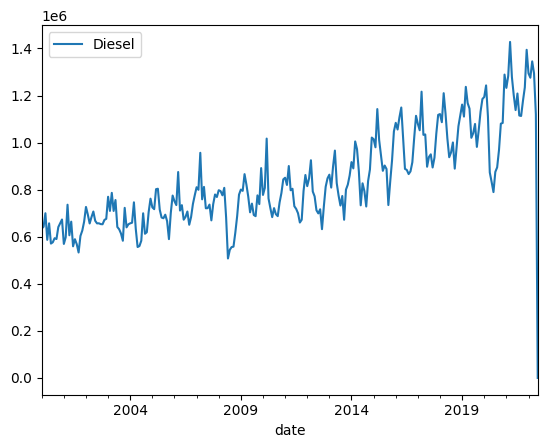

In [50]:
CONSUME.plot(x='date', y='Diesel', style='-')

<AxesSubplot:xlabel='date'>

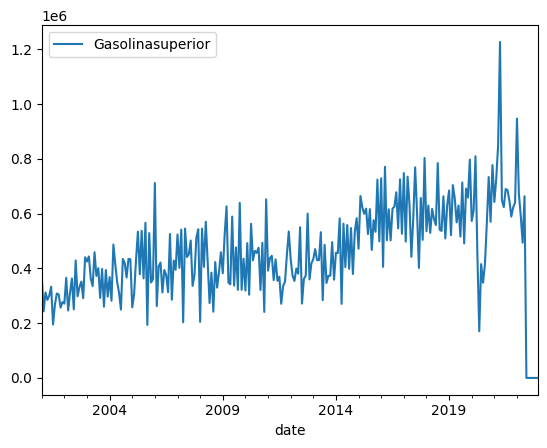

In [48]:
IMPORT.plot(x='date', y='Gasolinasuperior', style='-')

<AxesSubplot:xlabel='date'>

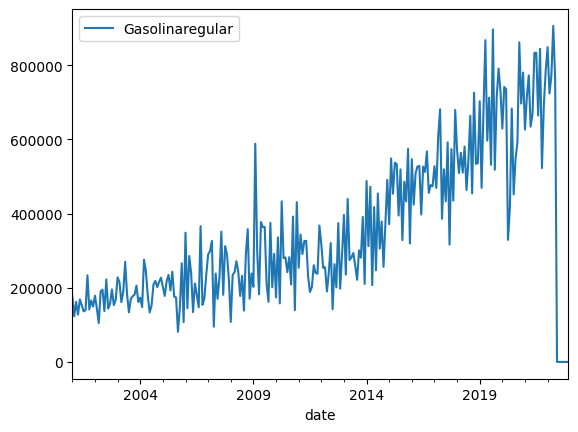

In [51]:
IMPORT.plot(x='date', y='Gasolinaregular', style='-')

<AxesSubplot:xlabel='date'>

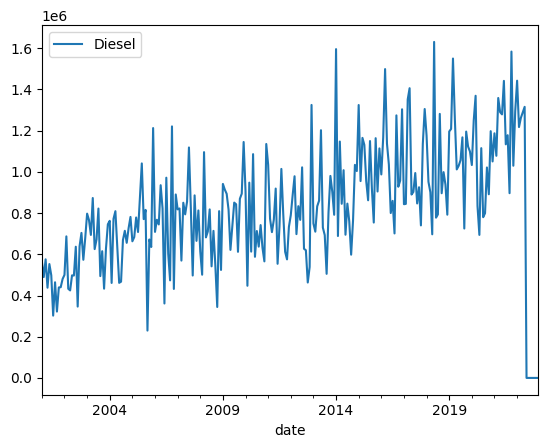

In [52]:
IMPORT.plot(x='date', y='Diesel', style='-')